 **Financial assets trend prediction using Machine Learning**


# Contents

1. Financial Data and Bars 
 - Form Bars
 - Summary and plot


2. Momentum Labeling
 - Trend Scanning
 - FB Prophet
 - Forward price movements


3. Prediction Model

 3.1. Get Features (X)
 - Market data & Technical Analysis & Microstructure Features
 - Sentiments with NLP
 
 3.2. Feature Engineering
 - Feature Scaling (MinMaxScaler)
 - Dimension Reduction (PCA/ Non Linear Autoencoder)
 
 3.3. Machine Learning Model
 - AutoML with *autogluon* and select the best model
 - Cross-Validation
 - Feature Importance

In [1]:
# lib
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
plt.style.use('tableau-colorblind10')

#feature
from sklearn import preprocessing
from sklearn.decomposition import FactorAnalysis, KernelPCA, PCA

#ML
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from mlutil import cross_validation

# deep learning
import keras

# Technical analysis
import ta
from features import getTA, tautil, ti_matrix

from labeling import trend_scanning
from prophet import Prophet

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
def figure_scatter(sc,close, title, vmin=None, vmax=None, cmap='bwr', figsize=(15,5)):
    plt.figure(figsize=figsize)
    plt.plot(close, linewidth=0.5,alpha=0.6)
    if (vmin==None) & (vmax==None):
        plt.scatter(close.loc[sc.index].index, close.loc[sc.index], c=sc,cmap=cmap, alpha=1)
    else:
        plt.scatter(close.loc[sc.index].index, close.loc[sc.index], c=sc,cmap=cmap, alpha=1,vmin=vmin,vmax=vmax)
    plt.colorbar()
    plt.title(title)
    plt.savefig('image/{}.png'.format(title))
    plt.show()

# Financial Data and Bars

## Form bars

- 자산: SPY (S&P500 ETF)
- 일별 데이터

In [4]:
import yfinance as yf
df_ = yf.download('SPY','2010-1-1')

[*********************100%***********************]  1 of 1 completed


## summary & plots

In [5]:
df = tautil.ohlcv(df_)
df.describe()

,open,high,low,close,volume
count,2919.000000,2919.000000,2919.000000,2919.000000,2.919000e+03
mean,217.805300,218.916406,216.586698,217.843576,1.218706e+08
std,79.034110,79.399916,78.629165,79.047015,7.394302e+07
min,103.110001,103.419998,101.129997,102.199997,2.027000e+07
25%,144.184998,144.555000,143.534996,144.090004,7.073130e+07
50%,207.389999,208.389999,206.500000,207.639999,1.023794e+08
75%,273.794998,275.324997,272.334991,274.065002,1.508687e+08
max,440.339996,441.850006,439.880005,441.760010,7.178287e+08


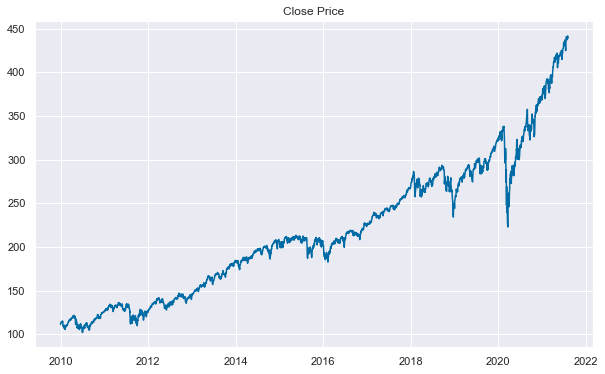

In [6]:
plt.figure(figsize=(10,6))
plt.title('Close Price')
plt.plot(df.close)
plt.show();

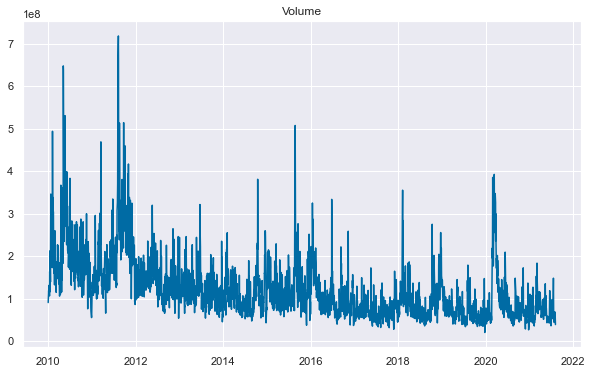

In [7]:
plt.figure(figsize=(10,6))
plt.title('Volume')
plt.plot(df.volume)
plt.show();

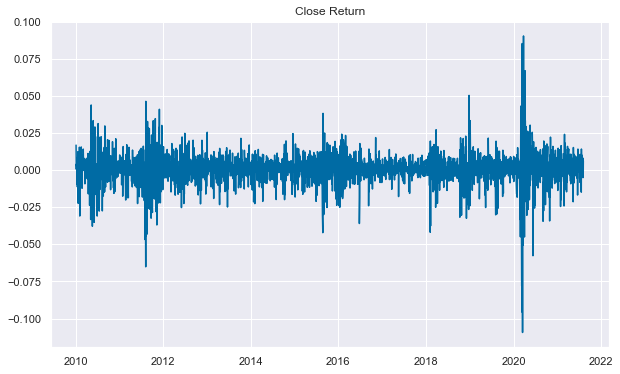

In [8]:
plt.figure(figsize=(10,6))
plt.title('Close Return')
plt.plot(df.close.pct_change())
plt.show();

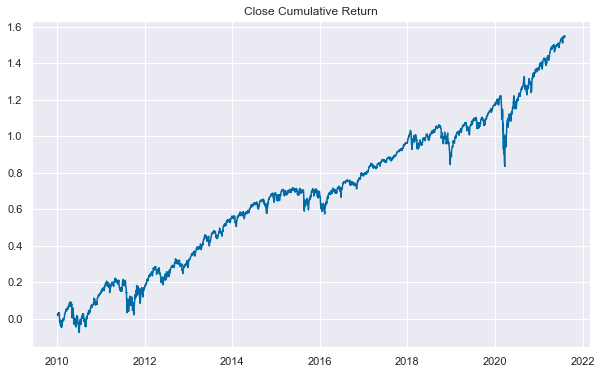

In [9]:
plt.figure(figsize=(10,6))
plt.title('Close Cumulative Return')
plt.plot(np.cumsum(df.close.pct_change()))
plt.show();

+ dollar volume, volume imbalance (buy-sell volume)

# Trend Labeling 

## Trend scanning

In [10]:
close = df.close
trend_df_ = trend_scanning.trend_scanning_labels(close,step=10)

In [11]:
trend_df = trend_df_[['t_value','bin']]

In [12]:
trend_bin = trend_df.bin.copy()

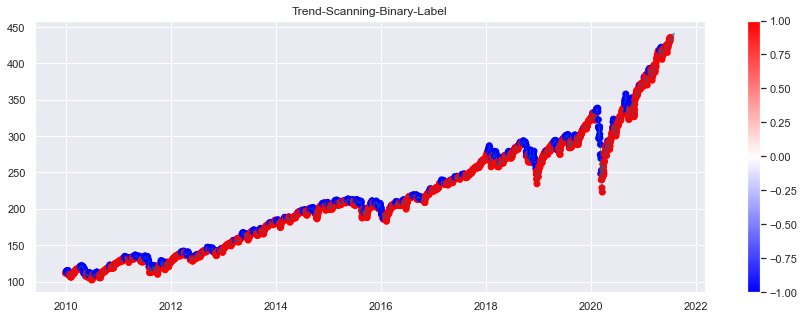

In [13]:
sc = trend_bin
title = 'Trend-Scanning-Binary-Label'

figure_scatter(sc,close,title)

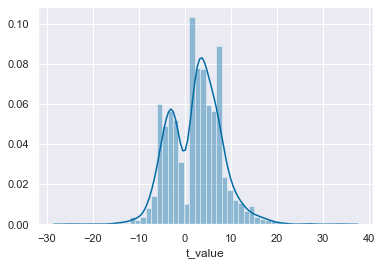

In [14]:
sns.distplot(trend_df.t_value.round())

In [15]:
trend_q = pd.qcut(trend_df.t_value,q=5,labels=[-2,-1,0,1,2],retbins=True)[0]

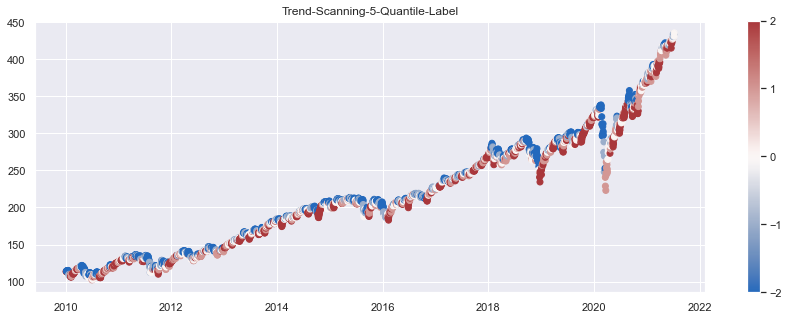

In [16]:
sc = trend_q
title = 'Trend-Scanning-5-Quantile-Label'

plt.figure(figsize=(15,5))
plt.scatter(close.loc[sc.index].index, close.loc[sc.index], c=sc,cmap='vlag', alpha=1)
cb = plt.colorbar(ticks=[-2,-1,0,1,2])
plt.title(title)
plt.show()

## Prophet trend

In [17]:
prophet_model = Prophet(growth='linear')

In [18]:
df_p = close.to_frame().reset_index().rename(columns={'Date':'ds','close':'y'})
prophet_model.fit(df_p)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


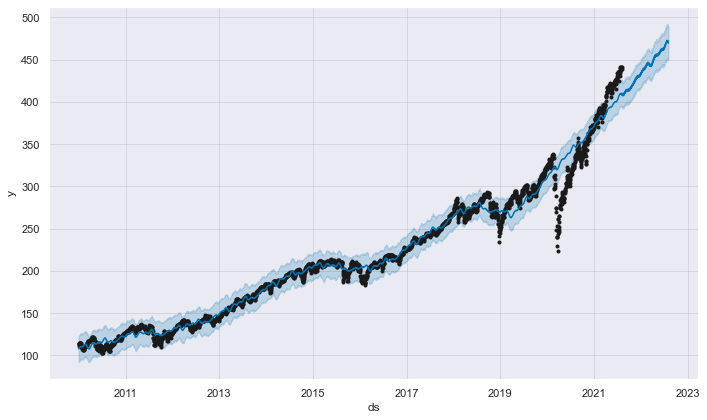

In [19]:
future = prophet_model.make_future_dataframe(periods=365)
#future['cap'] = 8.5
fcst = prophet_model.predict(future)
fig = prophet_model.plot(fcst)

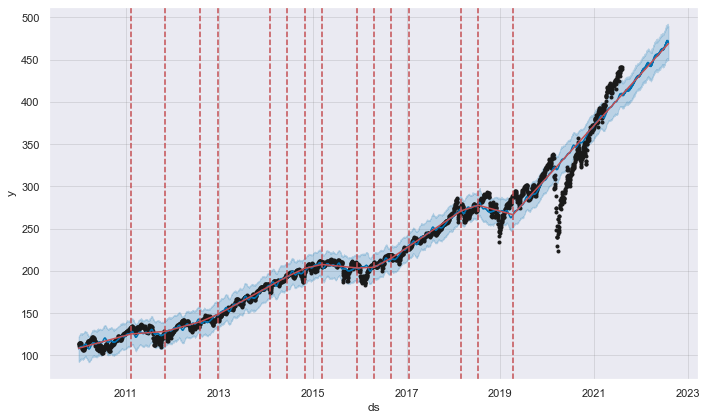

In [20]:
from prophet.plot import add_changepoints_to_plot
fig = prophet_model.plot(fcst)
a = add_changepoints_to_plot(fig.gca(), prophet_model, fcst)

CHOOSE y

In [42]:
y = trend_bin.copy().rename('y').to_frame()

# Prediction Model

 ## Get Features (X)
 
 ###  Market data

Market
- Techincal indicators with market data


In [43]:
df_ = df.copy()

In [44]:
windows = [20,40,60]
ti_signal = ti_matrix.get_all_signal(df_,windows)

In [45]:
windows_mom = [1,5,10]
windows_std = [10,20,60]

mom_std = tautil.mom_std(df_, windows_mom,windows_std)

In [46]:
mts= [1,2,3] #multipliers
TA = getTA.get_ta_window1(df_, mts)

Market Microstructures


In [47]:
# For bar data
from features import microstructure_features as mf

In [48]:
kyle_l = mf.get_bar_based_kyle_lambda(df.close,df.volume).rename('kyle_lambda')
bpv = mf.get_bekker_parkinson_vol(df.high,df.low).rename('bekker_parkinson_vol')
corwin = mf.get_corwin_schultz_estimator(df.high,df.low).rename('corwin_schultz_estimator')
#vpin = mf.get_vpin(volume, buy_volume).rename('vpin')

micro_features = pd.concat([kyle_l,bpv,corwin],axis=1)

mkt = pd.concat([ti_signal,mom_std,TA,micro_features],axis=1)

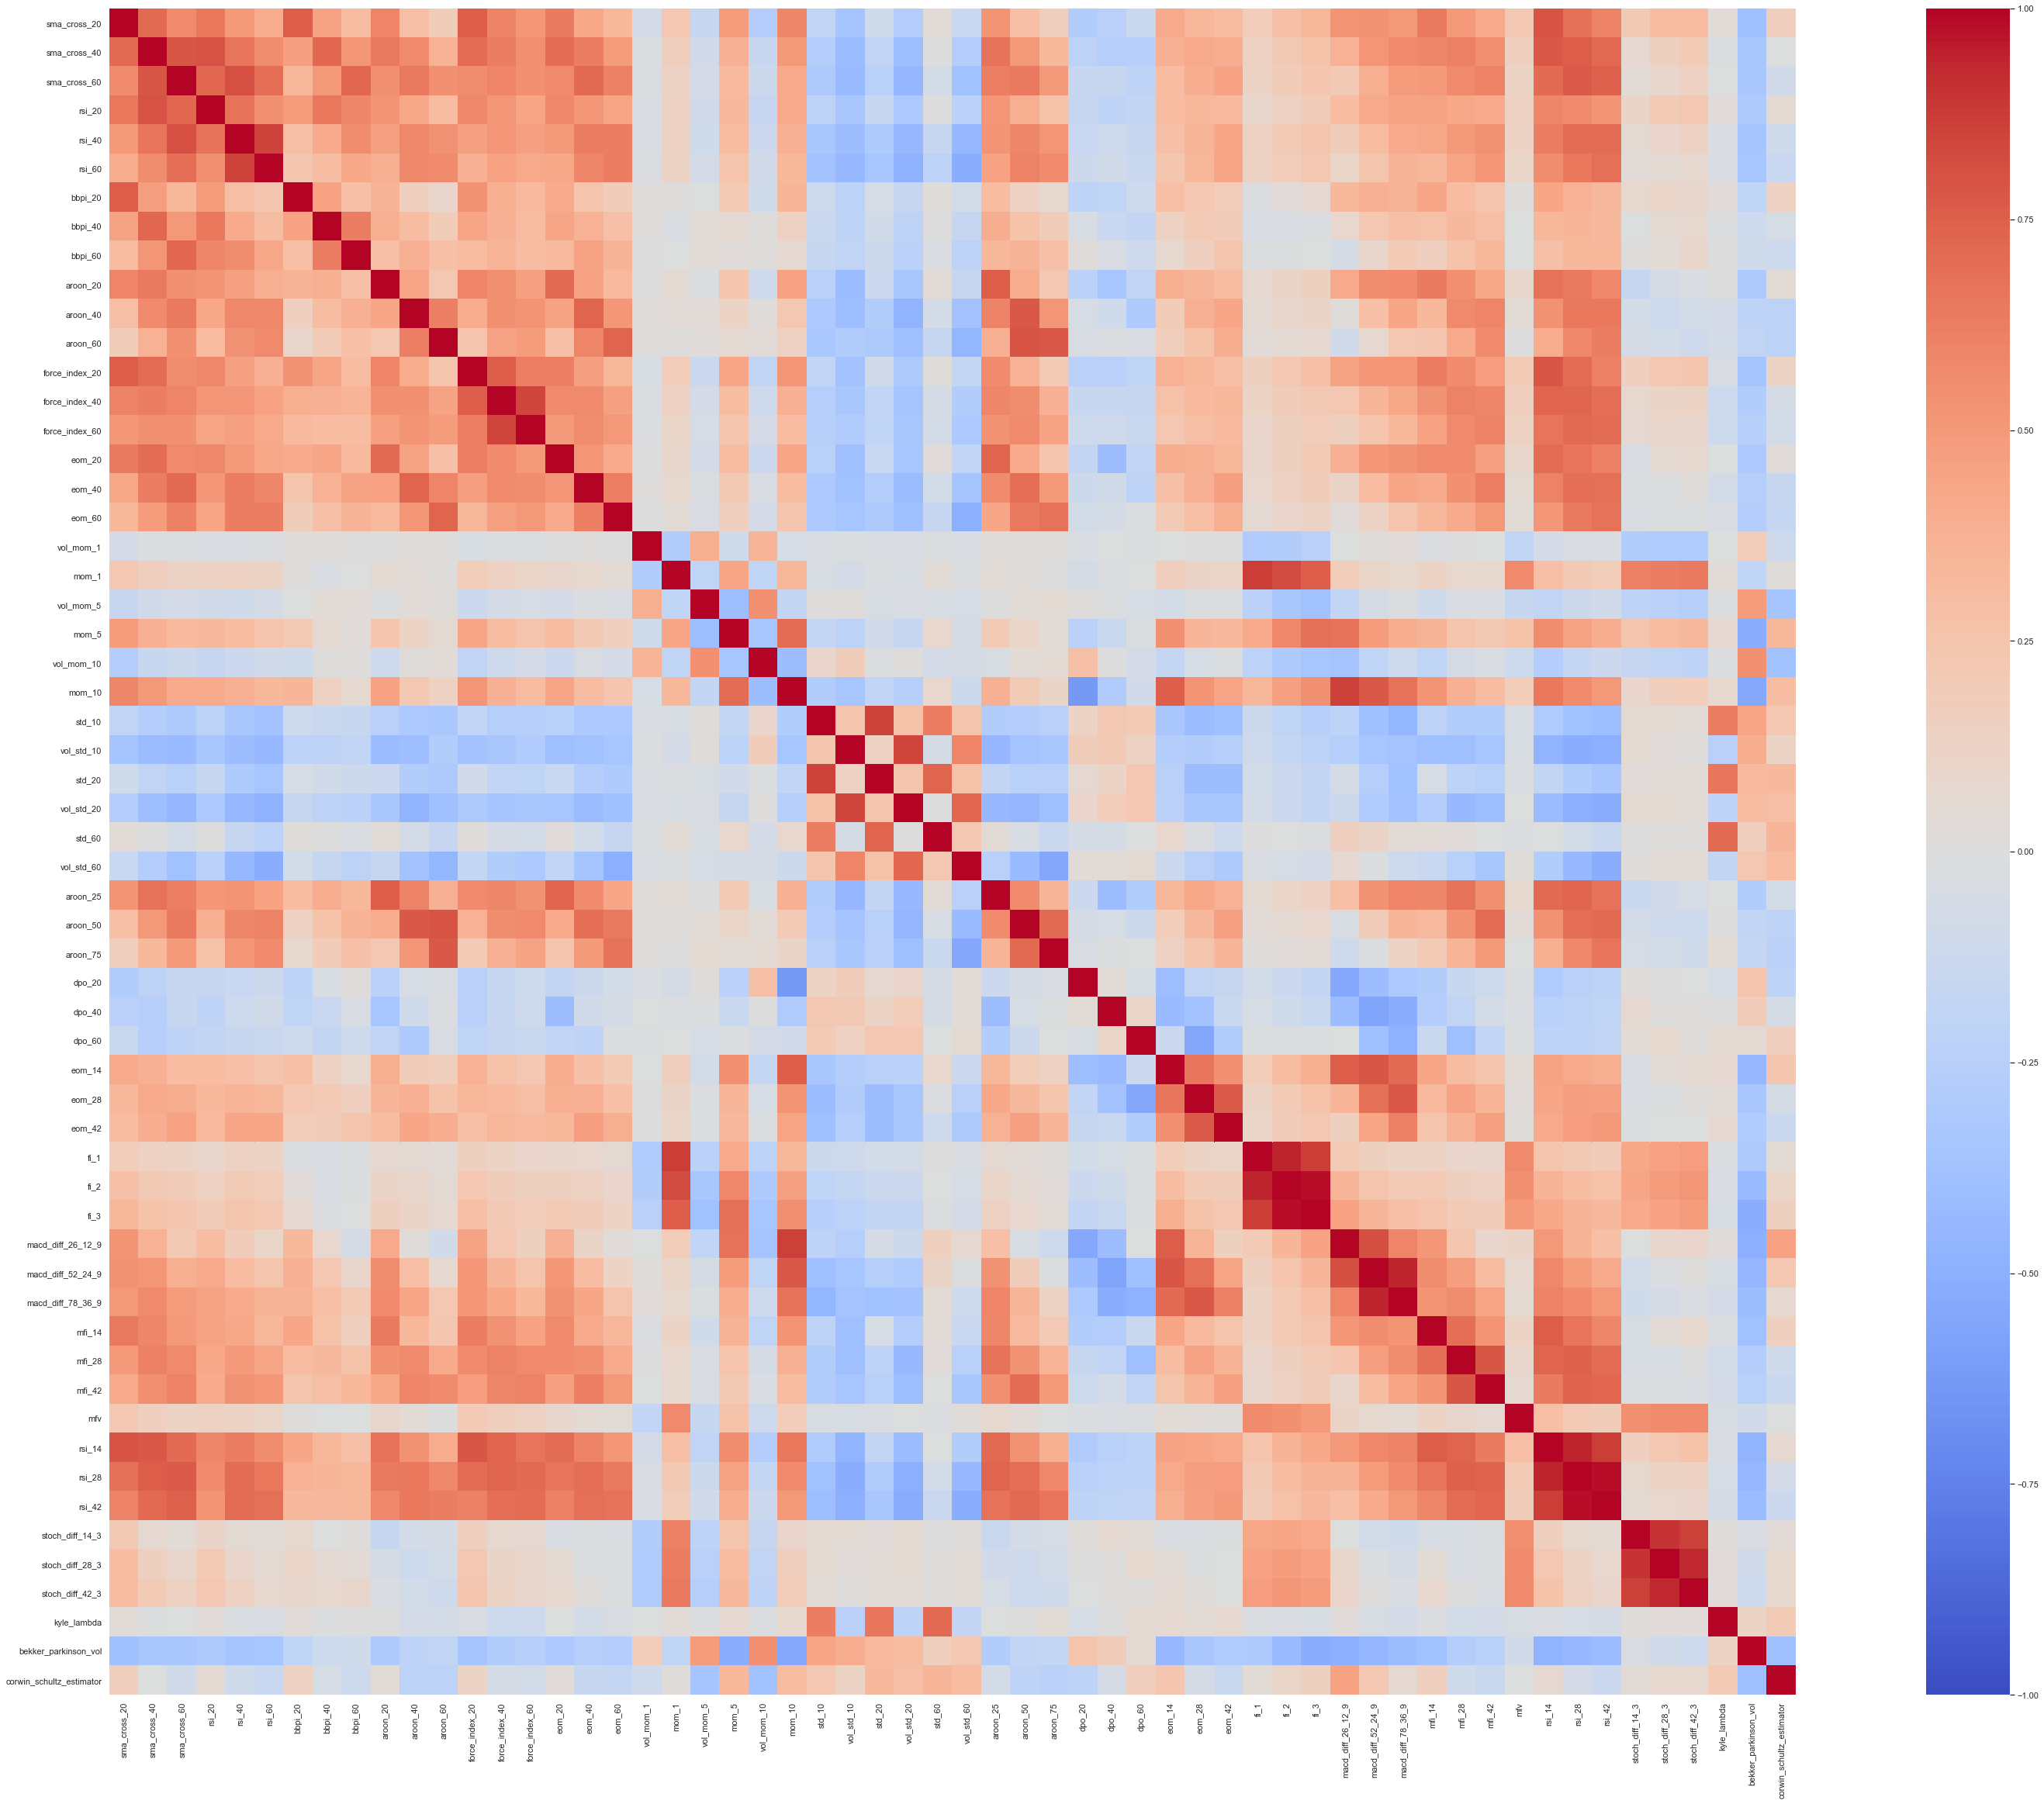

In [49]:
corr = mkt.corr()

plt.figure(figsize=(60,40))
sns.heatmap(corr, cmap='coolwarm', vmin=-1,vmax=1, square=True)
plt.savefig('image/feature_corr.png')
plt.show()

In [50]:
# Highly correlated market features

h = 0.75
where = (abs(corr)>h) & (corr<1)

hc_list =[]
for i in range(len(np.where(where)[0])):
    hc_list.append(sorted([corr.columns[np.where(where)[0][i]], corr.columns[np.where(where)[1][i]]]))
hc_list = np.array(sorted(hc_list))[::2,:]
hc_list

array([['aroon_20', 'aroon_25'],
       ['aroon_40', 'aroon_50'],
       ['aroon_50', 'aroon_60'],
       ['aroon_60', 'aroon_75'],
       ['bbpi_20', 'sma_cross_20'],
       ['eom_14', 'macd_diff_26_12_9'],
       ['eom_14', 'macd_diff_52_24_9'],
       ['eom_14', 'mom_10'],
       ['eom_28', 'eom_42'],
       ['eom_28', 'macd_diff_78_36_9'],
       ['fi_1', 'fi_2'],
       ['fi_1', 'fi_3'],
       ['fi_1', 'mom_1'],
       ['fi_2', 'fi_3'],
       ['fi_2', 'mom_1'],
       ['fi_3', 'mom_1'],
       ['force_index_20', 'force_index_40'],
       ['force_index_20', 'rsi_14'],
       ['force_index_20', 'sma_cross_20'],
       ['force_index_40', 'force_index_60'],
       ['macd_diff_26_12_9', 'macd_diff_52_24_9'],
       ['macd_diff_26_12_9', 'mom_10'],
       ['macd_diff_52_24_9', 'macd_diff_78_36_9'],
       ['macd_diff_52_24_9', 'mom_10'],
       ['mfi_14', 'rsi_14'],
       ['mfi_28', 'mfi_42'],
       ['rsi_14', 'rsi_28'],
       ['rsi_14', 'rsi_42'],
       ['rsi_14', 'sma_cross_20']

### Sentiments

We can get features from Natural Language Process.

Working on this.

In [51]:
## OVERALL

In [52]:
raw_X = mkt.shift(1).copy()

In [53]:
'''
for i in raw_X.columns:
    plt.figure(figsize=(5,0.5))
    plt.plot(raw_X[i])
    plt.legend([i])
'''

'\nfor i in raw_X.columns:\n    plt.figure(figsize=(5,0.5))\n    plt.plot(raw_X[i])\n    plt.legend([i])\n'

## Cross-Validation

In [58]:
tmp_df = raw_X.join(y).dropna()

In [60]:
# Choose one.

cv = cross_validation.CombPurgedKFoldCV(n_splits=5,n_test_splits=2,embargo_td=pd.Timedelta('1D'))
#cv = cross_validation.PurgedWalkForwardCV(n_splits=5,n_test_splits=1)

In [61]:
train_set, test_set = cv.split(tmp_df.iloc[:,:-1],tmp_df.iloc[:,-1])

ValueError: pred_times should be a pandas Series.

For feature engineering we have to split train and test periods.

## Feature Engineering

### Feature Scaling

Do it train, test data seperately.
I fit the scaler only on the training dataset and then transform the test set.

*Due to computational cost (in autoencoders), I did scaling and dimension-reduction of index of meta-labels'.*


MINMAX

In [38]:
train_index = y.loc[:'2017-1']
test_index = y.loc['2017-1':]

In [39]:
raw_X_train = raw_X.loc[train_index.index].dropna()
raw_X_test = raw_X.loc[test_index.index].dropna()

In [40]:
scaler = preprocessing.MinMaxScaler((0,1))
scaler.fit(raw_X_train)

scaled_X_train = pd.DataFrame(scaler.transform(raw_X_train),index=raw_X_train.index,columns=raw_X.columns)
scaled_X_test = pd.DataFrame(scaler.transform(raw_X_test),index=raw_X_test.index,columns=raw_X.columns)

### Dimension Reduction
- PCA - linear
- Deep Autoencoder (in process) - non-linear

CNN-autoencoder

https://github.com/jo-cho/machine-learning-for-trading/blob/master/18_convolutional_neural_nets/07_cnn_for_trading.ipynb

https://github.com/jo-cho/ML_Finance_Codes/blob/master/Chapter8-Advanced-NNs/ML_in_Finance-RNNs-Bitcoin.ipynb

In [66]:
# PCA
n=5

#pca = PCA(n)
#pca = FactorAnalysis(n)
pca = KernelPCA(n, kernel='rbf')

pca.fit(scaled_X_train)

pca_X_train = pd.DataFrame(pca.transform(scaled_X_train),columns = ['pc_{}'.format(i) for i in range(n)], index=scaled_X_train.index)

pca_X_test = pd.DataFrame(pca.transform(scaled_X_test),columns = ['pc_{}'.format(i) for i in range(n)], index=scaled_X_test.index)

In [67]:
corr_pca = pd.concat([pca_X_train,scaled_X_train],axis=1).corr()

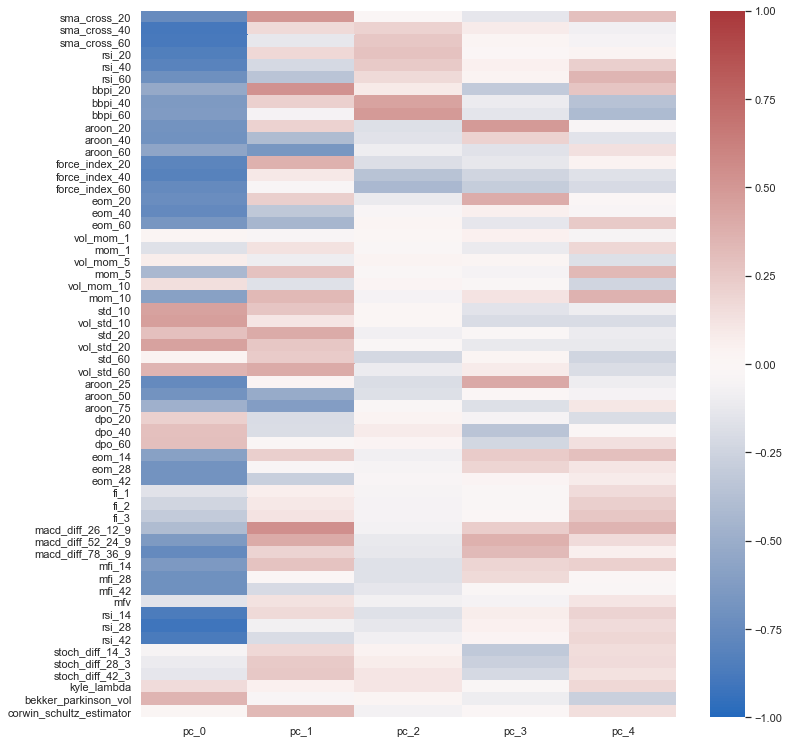

In [68]:
f = plt.figure(figsize=(12, 13))
sns.heatmap(corr_pca.iloc[:n,n:].T,cmap='vlag',vmin=-1,vmax=1)
plt.show();

look out for binary features

# Machine Learning Model

## Hyper parameter tuning

In [69]:
train_X = scaled_X_train.copy()
# or
#train_X= pca_X_train.copy()

test_X = scaled_X_test.copy()
# or
#test_X= pca_X_test.copy()<Increasing p (probability of winning)>

In [70]:
train_data = train_X.join(train_y).dropna()
test_data = test_X.join(test_y).dropna()

## ML Models

CROSS_VALIDATION

https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4

### Random Forest (Ensemble tree model(

In [71]:
rfc = RandomForestClassifier()

In [72]:
skfold = StratifiedKFold(5)

In [74]:
split = skfold.split(train_data.iloc[:,:-1],train_data.iloc[:,-1])

### Support Vector Machine (SVM)

In [47]:
y_true2 = test_data.y
y_pred2 = predictor.predict(test_data, model=best_model)

print(best_model, "'s predictions:  \n", y_pred2)
perf = predictor.evaluate_predictions(y_true=y_true2, y_pred=y_pred2, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.5319284374162423
Evaluations on test data:
{
    "accuracy": 0.5319284374162423,
    "balanced_accuracy": 0.5303322708383075,
    "mcc": 0.062002594565836566,
    "f1": 0.5788188477887312,
    "precision": 0.5328596802841918,
    "recall": 0.6334543055097328
}


RandomForestEntr 's predictions:  
 timestamp
2021-04-01 00:00:00   -1.0
2021-04-01 00:05:00    1.0
2021-04-01 00:10:00    1.0
2021-04-01 00:15:00    1.0
2021-04-01 00:20:00    1.0
                      ... 
2021-07-13 22:05:00    1.0
2021-07-13 22:10:00    1.0
2021-07-13 22:15:00    1.0
2021-07-13 22:20:00    1.0
2021-07-13 22:25:00    1.0
Name: y, Length: 29848, dtype: float64


## Feature Importance

In autogluon,

- A feature's importance score represents the performance drop that results when the model makes predictions on a perturbed copy of the data where this feature's values have been randomly shuffled across rows.
- A feature score of 0.01 would indicate that the predictive performance dropped by 0.01 when the feature was randomly shuffled.
- The higher the score a feature has, the more important it is to the model's performance.
- If a feature has a negative score, this means that the feature is likely harmful to the final model, and a model trained with the feature removed would be expected to achieve a better predictive performance.

In [48]:
fi = predictor.feature_importance(test_data, model=best_model, silent=True)

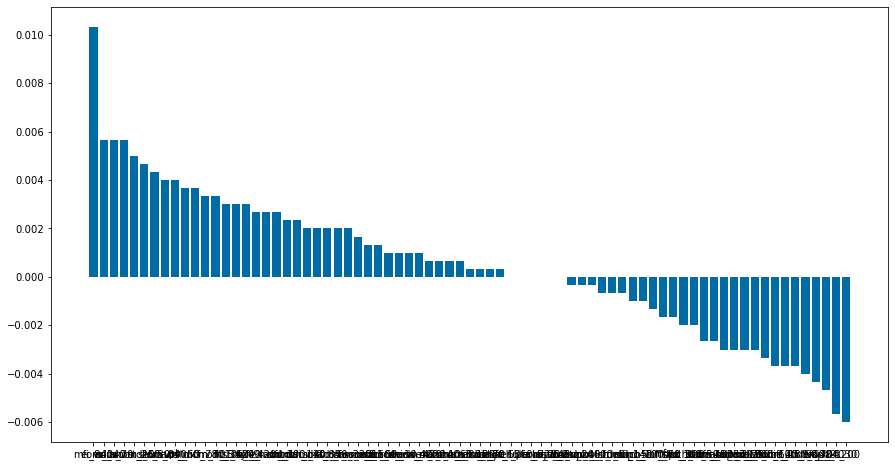

In [49]:
plt.figure(figsize=(15,8))
plt.bar(fi.index,fi.importance)
plt.show()

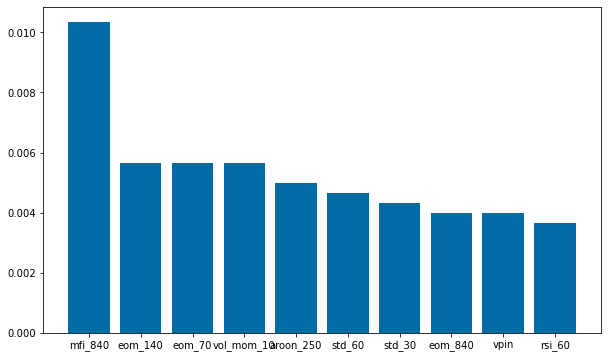

In [50]:
fi_top = fi.head(10)
plt.figure(figsize=(10,6))
plt.bar(fi_top.index,fi_top.importance)
plt.show()

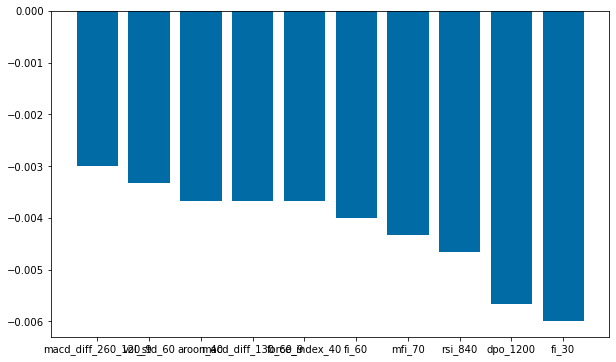

In [51]:
fi_bottom = fi.tail(10)
plt.figure(figsize=(10,6))
plt.bar(fi_bottom.index,fi_bottom.importance)
plt.show()

In [53]:
fi['rank'] = np.arange(len(fi))
fi

,importance,stddev,p_value,n,p99_high,p99_low,rank
mfi_840,0.010333,0.004933,0.034137,3,0.038599,-0.017933,0
eom_140,0.005667,0.007638,0.163745,3,0.049431,-0.038098,1
eom_70,0.005667,0.008737,0.189001,3,0.055730,-0.044397,2
vol_mom_10,0.005667,0.002309,0.025576,3,0.018900,-0.007566,3
aroon_250,0.005000,0.006083,0.145262,3,0.039855,-0.029855,4
...,...,...,...,...,...,...,...
fi_60,-0.004000,0.005196,0.842997,3,0.025775,-0.033775,70
mfi_70,-0.004333,0.003055,0.933333,3,0.013172,-0.021839,71
rsi_840,-0.004667,0.005774,0.851763,3,0.028416,-0.037749,72
dpo_1200,-0.005667,0.018037,0.679555,3,0.097687,-0.109021,73


In [60]:
rank = fi.rank()['rank']

In [62]:
rank.index

Index(['mfi_840', 'eom_140', 'eom_70', 'vol_mom_10', 'aroon_250', 'std_60',
       'std_30', 'eom_840', 'vpin', 'rsi_60', 'vol_mom_30',
       'macd_diff_780_360_9', 'mom_5', 'fi_10', 'rsi_420', 'rsi_40', 'mfi_420',
       'kyle_lambda', 'mom_1', 'std_100', 'of_mom_30', 'rsi_140',
       'stoch_diff_840_3', 'std_5', 'sma_cross_20', 'vol_mom_5', 'of_mom_1',
       'aroon_1500', 'eom_60', 'of_mom_10', 'sma_cross_40', 'force_index_20',
       'eom_420', 'stoch_diff_140_3', 'mom_10', 'aroon_60', 'mom_30',
       'sma_cross_60', 'rsi_20', 'rsi_70', 'bbpi_60', 'macd_diff_1560_720_9',
       'corwin_schultz_estimator', 'bekker_parkinson_vol', 'eom_20', 'bbpi_40',
       'fi_5', 'aroon_20', 'eom_40', 'dpo_600', 'vol_std_5', 'vol_mom_1',
       'of_mom_5', 'mfi_140', 'dpo_100', 'stoch_diff_70_3', 'mfv',
       'vol_std_100', 'dpo_200', 'vol_std_30', 'stoch_diff_420_3', 'aroon_125',
       'force_index_60', 'bbpi_20', 'aroon_750', 'macd_diff_260_120_9',
       'vol_std_60', 'aroon_40', 'macd_dif